In [1]:
import numpy as np
import os
import struct

In [2]:
def load_mnist(path, kind):
    labels_path = os.path.join(path, '%s-labels.idx1-ubyte' %kind)
    images_path = os.path.join(path,'%s-images.idx3-ubyte' %kind)
   
    with open(labels_path, 'rb') as lb_path:
        magic, n = struct.unpack('>II', lb_path.read(8))
        labels = np.fromfile(lb_path, dtype=np.uint8)
    
    with open(images_path, 'rb') as images_path:
        magic, num, rows, cols = struct.unpack(">IIII", images_path.read(16))
        images = np.fromfile(images_path, dtype=np.uint8).reshape(len(labels), 784)
    return images, labels

In [3]:
X_train, y_train = load_mnist('.\data', 'train')

In [4]:
X_test, y_test = load_mnist('.\data', 't10k')

In [5]:
X_train.shape

(60000, 784)

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

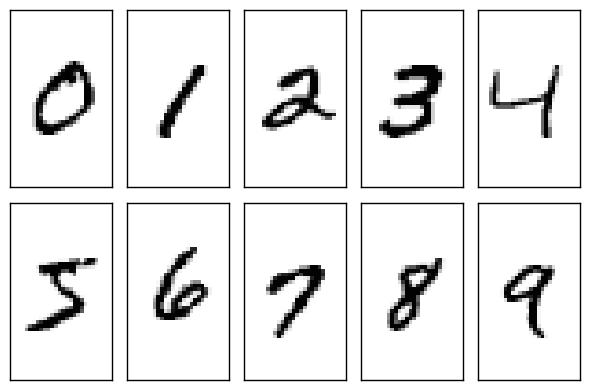

In [7]:
fig, ax = plt.subplots(nrows=2, ncols=5,sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X_train[y_train == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation= 'nearest')
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    plt.tight_layout()

In [8]:
from scipy.special import expit
import sys

In [9]:
from IPython.display import Image

![title](data/equations.png)

In [77]:
class MLP(object):
    def __init__(self, n_output, n_features, n_hidden=30, L1=0.0, L2=0.0, epochs=500, eta=0.0001, alpha=0.0, \
                 decrease_const=0.0, shuffle=True, minibatches=1, random_state=1):
        self.n_output = n_output
        self.n_features = n_features
        self.n_hidden = n_hidden
        self.L1 = L1
        self.L2 = L2
        self.epochs = epochs
        self.eta = eta
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches
        self.W1, self.W2 = self.__initialize_weights()
        self.cost = []
        
    def __initialize_weights(self):
        W1 = np.random.uniform(low=-1, high=1, size=self.n_hidden * (self.n_features + 1))
        W1 = W1.reshape((self.n_hidden, self.n_features + 1))
        
        W2 = np.random.uniform(low=-1, high=1, size=self.n_output * (self.n_hidden + 1))
        W2 = W2.reshape((self.n_output, self.n_hidden + 1))
        
        self.print_shape(W1, "W1")
        self.print_shape(W2, "W2")
        return W1, W2
    
    def __sigmoid(self, z):
        return 1/(1+np.exp(-z))
    
    def __sigmoid_gradient(self, z):
        sg = self.__sigmoid(z)
        return sg * (1-sg)
    
    def __feedforward(self, X):
        N = np.ones((X.shape[0], X.shape[1]+1),dtype=np.int8)
        N[:,1:] = X
        A1 = N #(n,k')
        
        Z2 = self.W1.dot(A1.T)
        A2 = self.__sigmoid(Z2)#(h,n)
        
        N = np.ones((A2.shape[0]+1, A2.shape[1]),dtype=np.int8)
        N[:-1,:]=A2
        A2 = N #(h',n)
        
        Z3 = self.W2.dot(A2)
        A3 = self.__sigmoid(Z3)#(o,n)
        
        return Z2, Z3, A1, A2, A3
    
    
    def __l1(self, l1):
        return l1 * (np.sum(np.abs(self.W1[:,1:])) + np.sum(np.abs(self.W2[:,1:])))
    
    def __l2(self, l2):
        return l2 * (np.sum(np.power(self.W1[:,1:],2)) + np.sum(np.power(self.W2[:,1:],2)))
    
    def __getcost(self, encoding, output):
        cost =  -encoding * np.log(output) - (1-encoding) * np.log(1 - output)
        l1 = self.__l1(self.L1)
        l2 = self.__l2(self.L2)
        return cost + l1 + l2
    
    def __back_propagate(self, encoding, A3, A2, A1, Z2, Z3):
        #W1(h,k') and W2(o,h')
        #A1(n,k')
        #Z2(h,n) and A2(h',n)
        #Z3(o,n) and A3(o,n) and encoding(o,n)
        
        self.print_shape(self.W1, "W1")
        self.print_shape(self.W2, "W2")
        self.print_shape(A1, "A1")
        self.print_shape(A2, "A2")
        self.print_shape(A3, "A3")
        self.print_shape(Z2, "Z2")
        self.print_shape(Z3, "Z3")
        
        delta3 = (A3 - encoding) * self.__sigmoid_gradient(Z3) #(o,n)
        grad3 = delta3.dot(A2.T) #(o,h')
        
        N = np.ones((Z2.shape[0] + 1, Z2.shape[1]), dtype=np.int8)
        N[1:,:] = Z2
        Z2 = N #(h',n)
        
        delta2 = self.W2.T.dot(delta3) * self.__sigmoid_gradient(Z2) #(h',n)
        delta2 = delta2[1:,:]
        grad2 = delta2.dot(A1) #(h',k')  
        
        self.print_shape(self.W1, "W1")
        self.print_shape(self.W2, "W2")
        self.print_shape(grad2, "grad2")
        self.print_shape(grad3, "grad3")
        
        grad2[:, 1:] += self.W1[:, 1:] *(self.L1 + self.L2)
        grad3[:, 1:] += self.W2[:, 1:] *(self.L1 + self.L2)
        
        return grad2, grad3
    
    def predict(self, X):
        A1, Z2, A2, Z3, A3 = self.__feedforward(X)
        y_pred = np.argmax(Z3, axis=0)
        return y_pred
    
    def __encode(self, y):
        y_encoded = np.zeros((self.n_output, y.shape[0]))
        for i,v in enumerate(y):
            y_encoded[v, i] = 1
        return y_encoded #(o,n)
    
    def fit(self, X, y, print_progress=False):
        X_data, y_data = X.copy(), y.copy()
        y_enc = self.__encode(y_data) #Each column is the results of the features for a given sample
        
        delta_W1_prev = np.zeros(self.W1.shape)
        delta_W2_prev = np.zeros(self.W2.shape)
        
        for i in range(self.epochs):
            self.eta /= (1 + self.decrease_const * i)
            
            if print_progress == True:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()
            
            if self.shuffle:
                idx = np.random.permutation(y_data.shape[0])
                X_data, y_enc = X_data[idx], y_enc[:,idx]
       
            
            batches = np.array_split(range(y_enc.shape[1]), self.minibatches)
            
            for idx in batches:
                
                #feedforward
                Z2, Z3, A1, A2, A3 = self.__feedforward(X_data[idx])
                cost = self.__getcost(y_enc[:,idx], A3)
                self.cost.append(cost)
                
                #compute gradient via backpropoagtion
                grad2, grad3 = self.__back_propagate(y_enc[:, idx], A3, A2, A1, Z2, Z3)
                
                #update weights
                delta_w1, delta_w2 = self.eta * grad2, self.eta * grad3
                
                self.W1 -= (delta_w1 + self.alpha * delta_W1_prev)
                self.W2 -= (delta_w2 + self.alpha * delta_W2_prev)
                
                delta_W1_prev, delta_W2_prev = delta_w1, delta_w2
        
        return self
    
    def print_shape(self, array, name):
         print("%s: (%d,%d)" % (name, array.shape[0],array.shape[1]))

In [78]:
nn = MLP(n_output=10, n_features=X_train.shape[1], n_hidden=30, L1=0.0, L2=0.0, epochs=500, eta=0.0001, alpha=0.0,\
         decrease_const=0.0, shuffle=True, minibatches=1, random_state=1)

W1: (30,785)
W2: (10,31)


In [79]:
nn.fit(X_train, y_train, False)

C:\Program Files\Anaconda3\Lib\site-packages\ipykernel\__main__.py:29: RuntimeWarning: overflow encountered in exp


W1: (30,785)
W2: (10,31)
A1: (60000,785)
A2: (31,60000)
A3: (10,60000)
Z2: (30,60000)
Z3: (10,60000)
W1: (30,785)
W2: (10,31)
grad2: (30,785)
grad3: (10,31)
W1: (30,785)
W2: (10,31)
A1: (60000,785)
A2: (31,60000)
A3: (10,60000)
Z2: (30,60000)
Z3: (10,60000)
W1: (30,785)
W2: (10,31)
grad2: (30,785)
grad3: (10,31)
W1: (30,785)
W2: (10,31)
A1: (60000,785)
A2: (31,60000)
A3: (10,60000)
Z2: (30,60000)
Z3: (10,60000)
W1: (30,785)
W2: (10,31)
grad2: (30,785)
grad3: (10,31)
W1: (30,785)
W2: (10,31)
A1: (60000,785)
A2: (31,60000)
A3: (10,60000)
Z2: (30,60000)
Z3: (10,60000)
W1: (30,785)
W2: (10,31)
grad2: (30,785)
grad3: (10,31)
W1: (30,785)
W2: (10,31)
A1: (60000,785)
A2: (31,60000)
A3: (10,60000)
Z2: (30,60000)
Z3: (10,60000)
W1: (30,785)
W2: (10,31)
grad2: (30,785)
grad3: (10,31)
W1: (30,785)
W2: (10,31)
A1: (60000,785)
A2: (31,60000)
A3: (10,60000)
Z2: (30,60000)
Z3: (10,60000)
W1: (30,785)
W2: (10,31)
grad2: (30,785)
grad3: (10,31)
W1: (30,785)
W2: (10,31)
A1: (60000,785)
A2: (31,60000)
A3

KeyboardInterrupt: 

In [ ]:
np.array_split(np.arange(0,len(y_train)),50)

## Why we take Z3 instead of A3 in predict method ?

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
x = np.arange(0,100)
y = 1 / (1+ np.exp(-x))
plt.plot(x,y)